# Instance Segmentation zonnepanelen

Dit notebook bevat de code die is gebruikt om de configs van de modellen aan te passen en de modellen te trainen en te testen. Dit notebook hoort bij het afstudeer onderzoek _"Instance segmentation van zonnepanelen op luchtfoto's"_

Er zijn tijdens dit onderzoek meerdere experimenten uitgevoerd. In onderstaande tabel zijn de experimentnummers en -namen weergegeven. Voor elk model is tijdens de training een pre-trained coco model gebruikt. Voor de hyperparamaters zijn de default instellingen van het model egbruikt. Wel is de learning rate aangepast op het moment dat deze ingesteld was voor 8 GPU training.

Voor het opzetten van deze notebook is gebruik gemaakt van code uit de MMDetection demo

| Naam | Model | Dataset | Epochs getraind | Gekozen epoch | Train tijd | Aangemaakte config | Opmerkingen |
|------|------|------|------|------|------|------|------|
|Exp_2| Mask R-CNN | Ortho | 24 | 21 | 71m 33.0s | mask-rcnn_r50-caffe_fpn_ms-poly-2x_zonnepaneel_ortho |
|Exp_13 | Mask R-CNN | Ortho | 36 | 21 | | mask-rcnn_r50-caffe_fpn_ms-poly-3x_zonnepaneel_ortho_2 | Exp_2 nog 12 iteraties bij getraind |
|Exp_3| Mask R-CNN | True-ortho | 36 | 18 | 97m 2.0s | mask-rcnn_r50-caffe_fpn_ms-poly-3x_zonnepaneel_true-ortho |
|Exp_4| YOLACT (R50) | True-ortho | 55 | 42 | 88m 26.1s | yolact_r50_1x8_e55_zonnepaneel_true-ortho |
|Exp_5| YOLACT (R50) | Ortho | 55 | 45 | 108m 7.0s | yolact_r50_1x8_e55_zonnepaneel_ortho |
|Exp_6| YOLACT (R101) | True-ortho | 55 | 36 | 117m 21.2s | yolact_r101_1x8_e55_zonnepaneel_true-ortho |
|Exp_11| YOLACT (R101) | Ortho | 55 | 42 | 137m 47.9s | yolact_r101_1x8_e55_zonnepaneel_ortho |
|Exp_8| Cascade Mask R-CNN | True-ortho | 12 | 11 | 167m 7.3s | cascade-mask-rcnn_r50-caffe_fpn_ms-3x_zonnepaneel_true-ortho |
|Exp_9| Cascade Mask R-CNN | True-ortho | 18 | 11 | 76m 4.5s | cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_true-ortho | Exp_8 nog 6 iteraties doorgetraind, gezien het onduidelijk was of hij al was gestabiliseerd|
|Exp_10| Cascade Mask R-CNN | Ortho | 12 | 11 | 179m 55.1s | cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_ortho |
|Exp_12| Cascade Mask R-CNN | Ortho | 18 | 11 | 88m 45.4s | cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_ortho_2 | Exp_10 nog 6 iteraties doorgetraind

## Mask R-CNN
De experimenten behorend bij het Mask R-CNN model

### Exp_2 & Exp_13: Ortho

In [20]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-2x_coco.py')

In [2]:
!mim download mmdet --config mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco --dest ./checkpoints

processing mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco...
mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth exists in /developement/experimenten/checkpoints
Successfully dumped mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py to /developement/experimenten/checkpoints


In [21]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_2'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-2x_zonnepaneel_ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [15]:
!python ../tools/train.py {config}

04/18 13:02:07 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1840345365
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

### Test the model
- Plotten learning curve
- Generen test resultaten
- Berekenen test metrics (segmentatie)
- Maken confusion matrix bboxes

Validation mAP:  [0.139, 0.16, 0.169, 0.107, 0.165, 0.182, 0.185, 0.182]


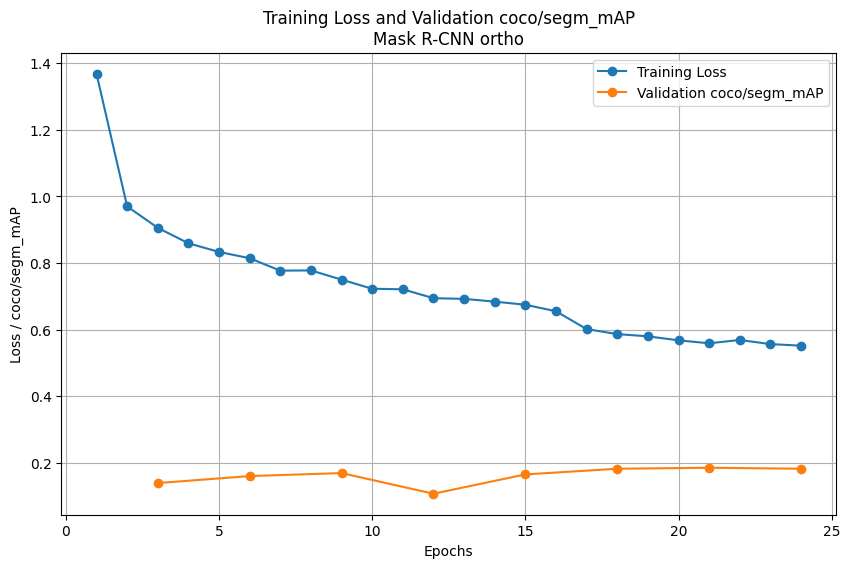

In [6]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_2/20240418_130207/vis_data/20240418_130207.json", "Mask R-CNN ortho")

Het creëren van de resultaten op de testafbeeldingen. 
In *Exp_2/detection_results* wordt een JSON bestand opgeslagen met de COCO mAP over de test afbeeldingen.

Daarnaast wordt er een bestand *results_exp2.pkl* opgeslagen waarin de daadwerkelijke segmentaties van de testafbeeldingen worden vastgelegd. 

In [6]:
!python ../tools/test.py \
../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-2x_zonnepaneel_ortho.py \
Exp_2/epoch_21.pth \
--work-dir Exp_2/detection_results \
--out results_exp2.pkl

04/19 06:26:06 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1661380027
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

Berekenen van de precision, recall en F1-score over de testdataset, met het eigen gemaakte script. Hiervoor wordt een json genamd *metrics* opgeslagen. En daarnaast ook een confusion matrix als png. (Met deze confusion matrix plot heb ikzelf niks gedaan, maar gezien mijn code gebasseerd was op het script om die matrix te genereren heb ik dat maar gewoon laten staan)

In [15]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-2x_zonnepaneel_ortho.py \
results_exp2.pkl \
Exp_2 \
--show

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 369/369, 0.1 task/s, elapsed: 2672s, ETA:     0sFigure(720x720)


#### Bij trainen mask R-CNN ortho
Deze had ik voor 24 epochs getraind, maar de meest optimale was vrij dicht bij het einde. Daarom bijgetraind tot 36 epochs ten behoeve van de learning curve.  

In [ ]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py')

In [ ]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# Train further from last epoch of exp_2
cfg.load_from = 'Exp_2/epoch_24.pth'
cfg.resume = True

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_13'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-3x_zonnepaneel_ortho_2.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [ ]:
!python ../tools/train.py {config}

05/10 07:28:33 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1960815326
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

Validation mAP:  [0.139, 0.16, 0.169, 0.107, 0.165, 0.182, 0.185, 0.182, 0.183, 0.18, 0.182, 0.181]


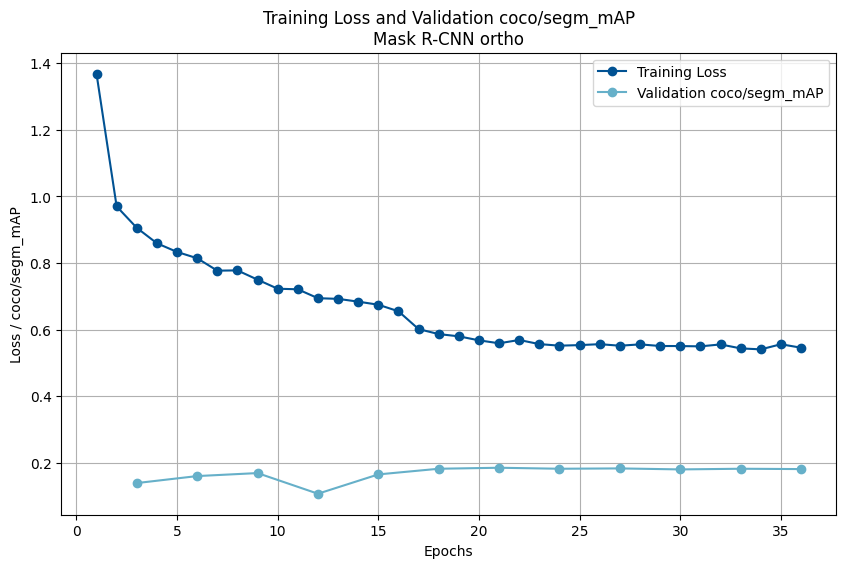

In [ ]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_13/20240510_072832/vis_data/20240510_072832.json", "Mask R-CNN ortho")

### Exp 3: Mask R-CNN true-ortho

In [31]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py')

In [32]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/true_ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_3'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-3x_zonnepaneel_true-ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [33]:
!python ../tools/train.py {config}

04/19 09:34:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 884631230
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

### Test the model
- Plotten train 
- Generen test resultaten
- Berekenen test metrics (segmentatie)
- Maken confusion matrix bboxes

Validation mAP:  [0.324, 0.349, 0.372, 0.38, 0.377, 0.39, 0.379, 0.339, 0.362, 0.368, 0.37, 0.365]


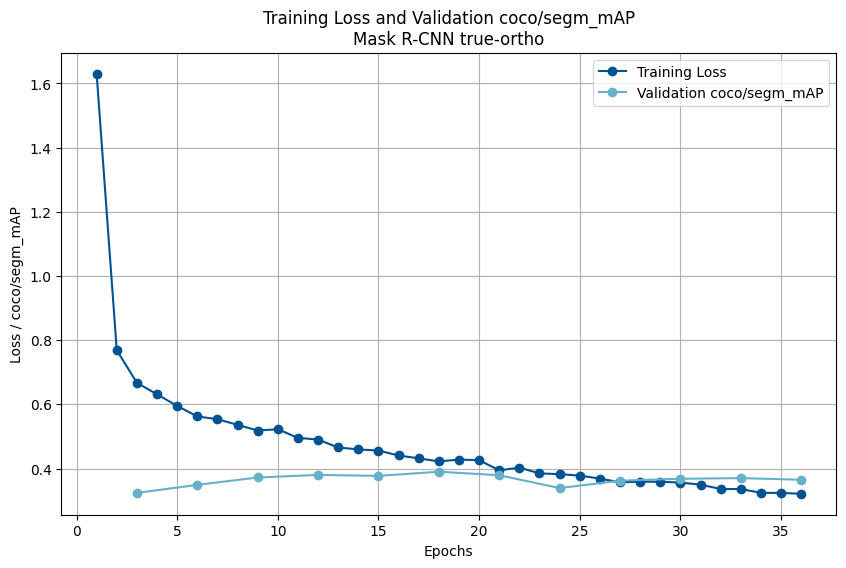

In [3]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_3/20240419_093447/vis_data/20240419_093447.json", "Mask R-CNN true-ortho")

In [35]:
!python ../tools/test.py \
../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-3x_zonnepaneel_true-ortho.py \
Exp_3/epoch_18.pth \
--work-dir Exp_3/detection_results \
--out results_exp3.pkl

04/19 11:15:33 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 752212080
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

In [12]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/mask-rcnn_r50-caffe_fpn_ms-poly-3x_zonnepaneel_true-ortho.py  \
results_exp3.pkl \
Exp_3 \
--show

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 282/282, 0.1 task/s, elapsed: 2166s, ETA:     0sFigure(720x720)


## YOLACT

### Experiment 4: YOLACT true-ortho
YOLACT op true-ortho afbeeldingen met ResNet50 backbone

In [38]:
from mmengine import Config
cfg = Config.fromfile('../configs/yolact/yolact_r50_1xb8-55e_coco.py')

In [40]:
!mim download mmdet --config yolact_r50_1x8_coco --dest ./checkpoints

processing yolact_r50_1x8_coco...
yolact_r50_1x8_coco_20200908-f38d58df.pth exists in /developement/experimenten/checkpoints
Successfully dumped yolact_r50_1x8_coco.py to /developement/experimenten/checkpoints


In [41]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/true_ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.bbox_head.num_classes = 1
cfg.model.mask_head.num_classes = 1

# We can still the pre-trained model to obtain a higher performance
cfg.load_from = 'checkpoints/yolact_r50_1x8_coco_20200908-f38d58df.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_4'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/yolact_r50_1x8_e55_zonnepaneel_true-ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [42]:
!python ../tools/train.py {config}

04/19 12:28:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1091189752
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

### Test the model
- Plotten train 
- Generen test resultaten
- Berekenen test metrics (segmentatie)
- Maken confusion matrix bboxes

Validation mAP:  [0.044, 0.041, 0.075, 0.101, 0.097, 0.098, 0.127, 0.126, 0.134, 0.137, 0.137, 0.15, 0.141, 0.161, 0.151, 0.147, 0.15, 0.15]


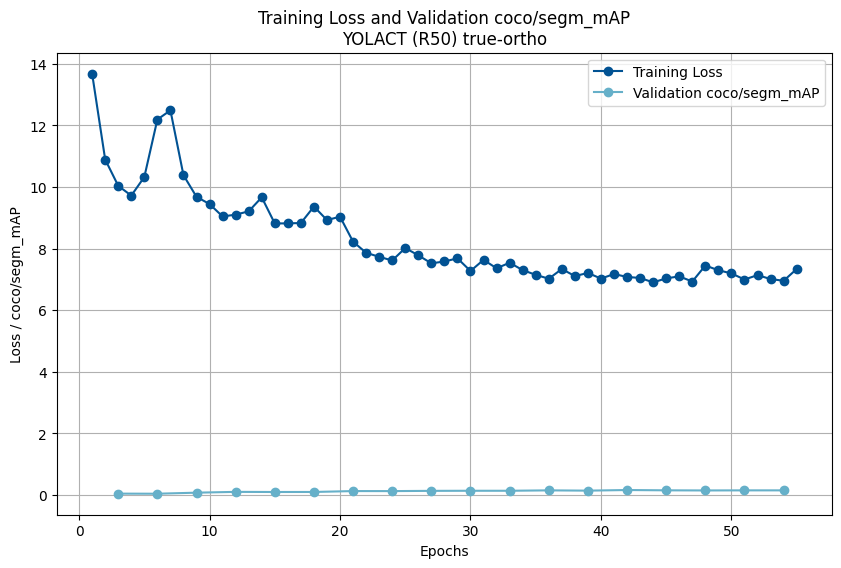

In [4]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_4/20240419_122822/vis_data/20240419_122822.json", "YOLACT (R50) true-ortho")

In [3]:
!python ../tools/test.py \
../configs/solar_panels/yolact_r50_1x8_e55_zonnepaneel_true-ortho.py \
Exp_4/epoch_42.pth \
--work-dir Exp_4/detection_results \
--out results_exp4.pkl

04/19 14:11:38 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1378678844
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

In [16]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/yolact_r50_1x8_e55_zonnepaneel_true-ortho.py \
results_exp4.pkl \
Exp_4 \
--show

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 282/282, 0.1 task/s, elapsed: 3942s, ETA:     0sFigure(720x720)


## Exp_5 YOLACT ortho
Yolact ortho met ResNet50 backbone

In [11]:
from mmengine import Config
cfg = Config.fromfile('../configs/yolact/yolact_r50_1xb8-55e_coco.py')

In [12]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.bbox_head.num_classes = 1
cfg.model.mask_head.num_classes = 1

# We can still the pre-trained model to obtain a higher performance
cfg.load_from = 'checkpoints/yolact_r50_1x8_coco_20200908-f38d58df.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_5'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/yolact_r50_1x8_e55_zonnepaneel_ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [5]:
!python ../tools/train.py {config}

04/22 06:14:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1963596938
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

### Test the model
- Plotten train 
- Generen test resultaten
- Berekenen test metrics (segmentatie)
- Maken confusion matrix bboxes

Validation mAP:  [0.01, 0.021, 0.037, 0.035, 0.034, 0.047, 0.049, 0.053, 0.056, 0.057, 0.057, 0.054, 0.059, 0.059, 0.06, 0.059, 0.06, 0.06]


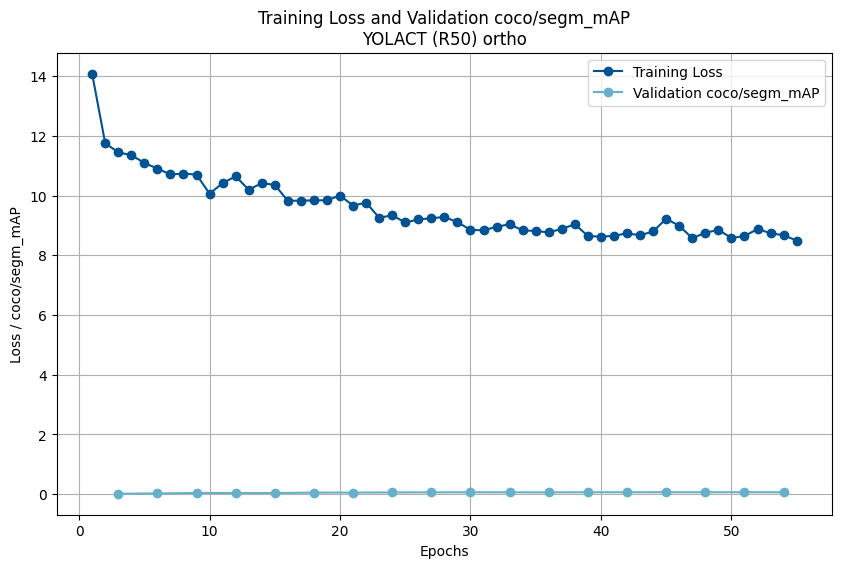

In [5]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_5/20240422_061434/vis_data/20240422_061434.json", "YOLACT (R50) ortho")

In [18]:
!python ../tools/test.py \
../configs/solar_panels/yolact_r50_1x8_e55_zonnepaneel_ortho.py \
Exp_5/epoch_45.pth \
--work-dir Exp_5/detection_results \
--out results_exp5.pkl

04/22 09:12:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 634298795
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

In [1]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/yolact_r50_1x8_e55_zonnepaneel_ortho.py \
results_exp5.pkl \
Exp_5 \
--show

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 369/369, 0.1 task/s, elapsed: 4906s, ETA:     0sFigure(720x720)


## Experiment 6: YOLACT true-ortho
Yolact voor true ortho, op basis van resnet 101

In [25]:
from mmengine import Config
cfg = Config.fromfile('../configs/yolact/yolact_r101_1xb8-55e_coco.py')

In [22]:
!mim download mmdet --config yolact_r101_1x8_coco --dest ./checkpoints

processing yolact_r101_1x8_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 MiB 36.1 MB/s eta 0:00:0000:0100:01
Successfully downloaded yolact_r101_1x8_coco_20200908-4cbe9101.pth to /developement/experimenten/checkpoints
Successfully dumped yolact_r101_1x8_coco.py to /developement/experimenten/checkpoints


In [26]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/true_ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.bbox_head.num_classes = 1
cfg.model.mask_head.num_classes = 1

# We can still the pre-trained model to obtain a higher performance
cfg.load_from = 'checkpoints/yolact_r101_1x8_coco_20200908-4cbe9101.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_6'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/yolact_r101_1x8_e55_zonnepaneel_true-ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [27]:
!python ../tools/train.py {config}

04/22 11:00:10 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 35503906
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute

### Test the model
- Plotten train 
- Generen test resultaten
- Berekenen test metrics (segmentatie)
- Maken confusion matrix bboxes

Validation mAP:  [0.013, 0.078, 0.095, 0.094, 0.111, 0.107, 0.132, 0.137, 0.137, 0.143, 0.146, 0.152, 0.157, 0.149, 0.151, 0.15, 0.152, 0.152]


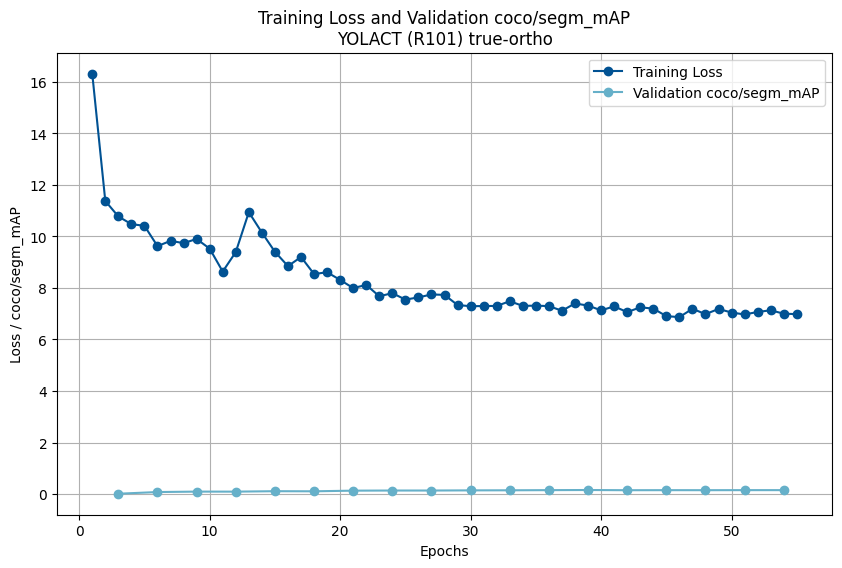

In [6]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_6/20240422_110010/vis_data/20240422_110010.json", "YOLACT (R101) true-ortho")

In [29]:
!python ../tools/test.py \
../configs/solar_panels/yolact_r101_1x8_e55_zonnepaneel_true-ortho.py \
Exp_6/epoch_36.pth \
--work-dir Exp_6/detection_results \
--out results_exp6.pkl

04/22 13:04:33 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 946763016
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

In [2]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/yolact_r101_1x8_e55_zonnepaneel_true-ortho.py \
results_exp6.pkl \
Exp_6 \
--show

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 282/282, 0.1 task/s, elapsed: 3975s, ETA:     0sFigure(720x720)


### Experiment 11: YOLACT ortho
Yolact voor ortho, op basis van resnet 101

In [ ]:
from mmengine import Config
cfg = Config.fromfile('../configs/yolact/yolact_r101_1xb8-55e_coco.py')

In [ ]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/ortho'

cfg.train_dataloader.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'

# Modify num classes of the model in box head and mask head
cfg.model.bbox_head.num_classes = 1
cfg.model.mask_head.num_classes = 1

# We can still the pre-trained model to obtain a higher performance
cfg.load_from = 'checkpoints/yolact_r101_1x8_coco_20200908-4cbe9101.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_11'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 3

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/yolact_r101_1x8_e55_zonnepaneel_ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [ ]:
!python ../tools/train.py {config}

04/26 06:28:47 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 650491174
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

Validation mAP:  [0.028, 0.02, 0.019, 0.016, 0.032, 0.023, 0.045, 0.047, 0.05, 0.047, 0.052, 0.054, 0.053, 0.057, 0.058, 0.057, 0.057, 0.058]


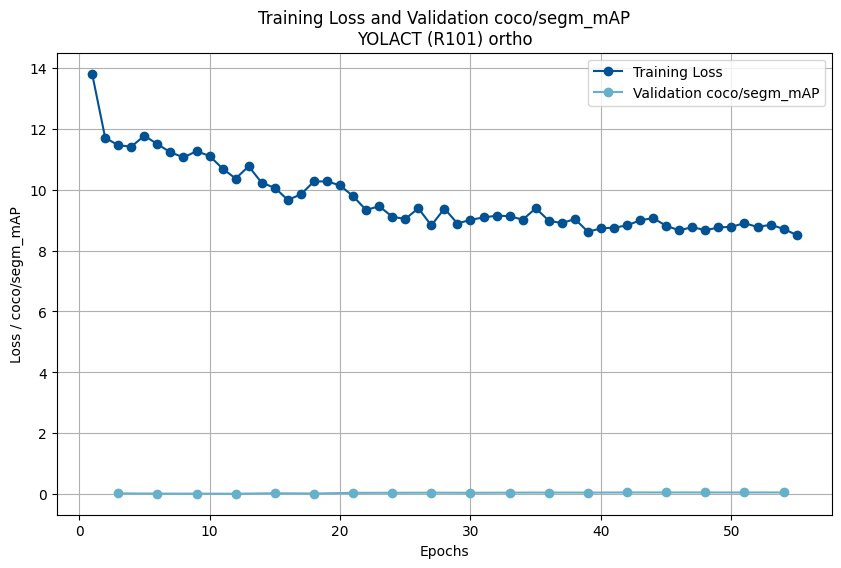

In [ ]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_11/20240426_062843/vis_data/20240426_062843.json", "YOLACT (R101) ortho")

In [ ]:
!python ../tools/test.py \
../configs/solar_panels/yolact_r101_1x8_e55_zonnepaneel_ortho.py \
Exp_11/epoch_42.pth \
--work-dir Exp_11/detection_results \
--out results_exp11.pkl

04/26 08:48:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 420844178
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

In [ ]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/yolact_r101_1x8_e55_zonnepaneel_ortho.py \
results_exp11.pkl \
Exp_11 \
--show

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 369/369, 0.1 task/s, elapsed: 4878s, ETA:     0sFigure(720x720)


## Cascade mask R-CNN
### Experiment 7 & 8: Cascade mask R-CNN true_ortho

In [10]:
from mmengine import Config
cfg = Config.fromfile('../configs/cascade_rcnn/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco.py')

In [25]:
!mim download mmdet --config cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco --dest ./checkpoints

processing cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 MiB 72.8 MB/s eta 0:00:0000:0100:01
Successfully downloaded cascade_mask_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210707_002651-6e29b3a6.pth to /developement/experimenten/checkpoints
Successfully dumped cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco.py to /developement/experimenten/checkpoints


In [11]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/true_ortho'

cfg.train_dataloader.dataset.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.val_evaluator.metric = ['bbox', 'segm']
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'
cfg.test_evaluator.metric = ['bbox', 'segm']

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained model to obtain a higher performance
cfg.load_from = 'checkpoints/cascade_mask_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210707_002651-6e29b3a6.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_8'

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 1
cfg.default_hooks.checkpoint.interval = 1

cfg.optim_wrapper.optimizer.lr = 0.02 / 8

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_zonnepaneel_true-ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [3]:
!python ../tools/train.py {config}

04/24 06:09:04 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 860270486
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

Validation mAP:  [0.26, 0.314, 0.34, 0.351, 0.35, 0.361, 0.377, 0.364, 0.366, 0.391, 0.398, 0.394]


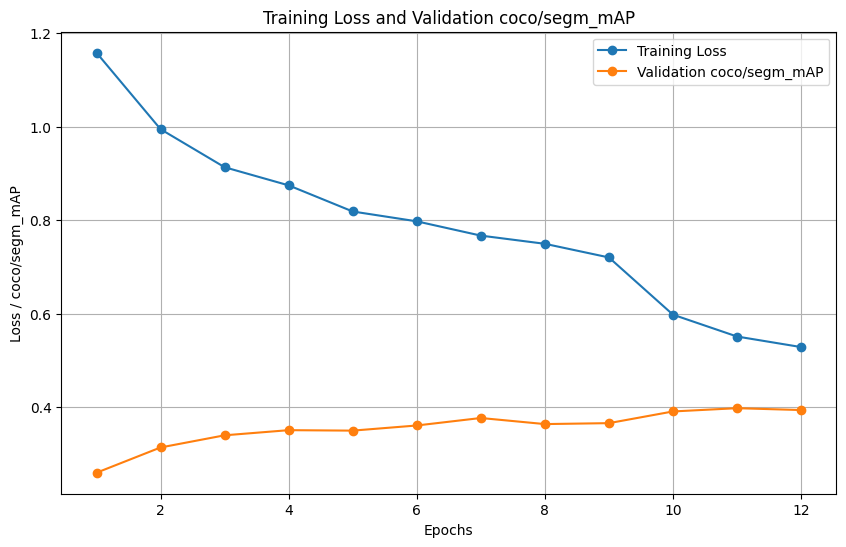

In [4]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_8/20240424_060901/vis_data/20240424_060901.json")

### Verder trainen
Nog wat extra epochs voor true-ortho cascade mask r-cnn

In [9]:
from mmengine import Config
cfg = Config.fromfile('../configs/cascade_rcnn/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco.py')

In [12]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/true_ortho'

cfg.train_dataloader.dataset.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.val_evaluator.metric = ['bbox', 'segm']
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'
cfg.test_evaluator.metric = ['bbox', 'segm']

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# Train further from last epoch of exp_8
cfg.load_from = 'Exp_8/epoch_12.pth'
cfg.resume = True

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_9'

# Adjust maximum number of epochs
cfg.train_cfg.max_epochs = 18

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 1
cfg.default_hooks.checkpoint.interval = 1

cfg.optim_wrapper.optimizer.lr = 0.02 / 8

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_true-ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [13]:
!python ../tools/train.py {config}

04/24 09:03:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1883414351
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

Validation mAP:  [0.26, 0.314, 0.34, 0.351, 0.35, 0.361, 0.377, 0.364, 0.366, 0.391, 0.398, 0.394, 0.396, 0.394, 0.395, 0.394, 0.394, 0.393]


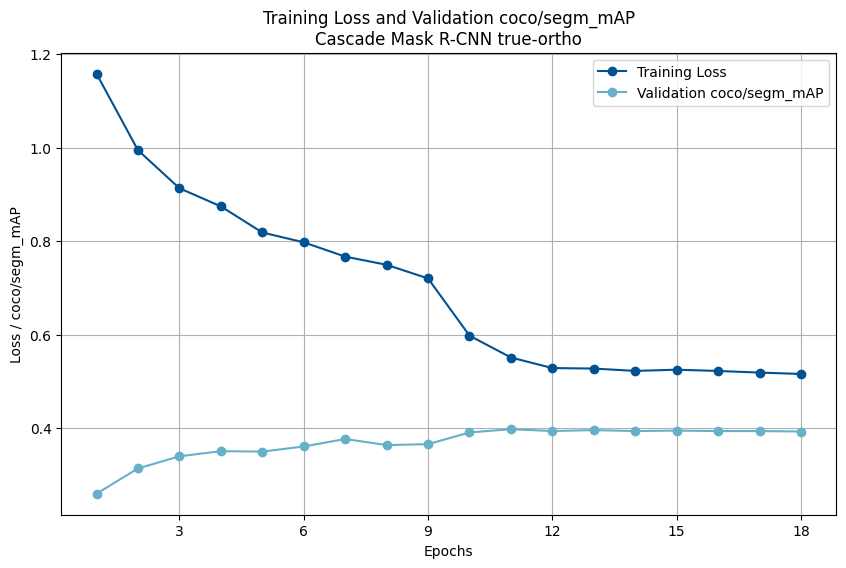

In [1]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_9/20240424_090352/vis_data/20240424_090352.json", "Cascade Mask R-CNN true-ortho")

In [3]:
!python ../tools/test.py \
../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_zonnepaneel_true-ortho.py \
Exp_8/epoch_11.pth \
--work-dir Exp_8/detection_results \
--out results_exp8.pkl

04/29 08:47:41 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1528698864
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

In [5]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_zonnepaneel_true-ortho.py \
results_exp8.pkl \
Exp_8 \
--show

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 282/282, 0.1 task/s, elapsed: 2053s, ETA:     0sFigure(720x720)


## Experiment 10: Cascade Mask R-CNN ortho

In [5]:
from mmengine import Config
cfg = Config.fromfile('../configs/cascade_rcnn/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco.py')

In [2]:
!mim download mmdet --config cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco --dest ./checkpoints

processing cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco...
cascade_mask_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210707_002651-6e29b3a6.pth exists in /developement/experimenten/checkpoints
Successfully dumped cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco.py to /developement/experimenten/checkpoints


In [8]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/ortho'

cfg.train_dataloader.dataset.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.val_evaluator.metric = ['bbox', 'segm']
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'
cfg.test_evaluator.metric = ['bbox', 'segm']

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained model to obtain a higher performance
cfg.load_from = 'checkpoints/cascade_mask_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210707_002651-6e29b3a6.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_10'

# Set validation and checkpoint intervals
cfg.train_cfg.val_interval = 1
cfg.default_hooks.checkpoint.interval = 1

cfg.optim_wrapper.optimizer.lr = 0.02 / 8

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_ortho.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [9]:
!python ../tools/train.py {config}

04/24 12:39:09 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1135432059
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

Validation mAP:  [0.136, 0.146, 0.156, 0.182, 0.196, 0.183, 0.189, 0.19, 0.177, 0.195, 0.201, 0.201]


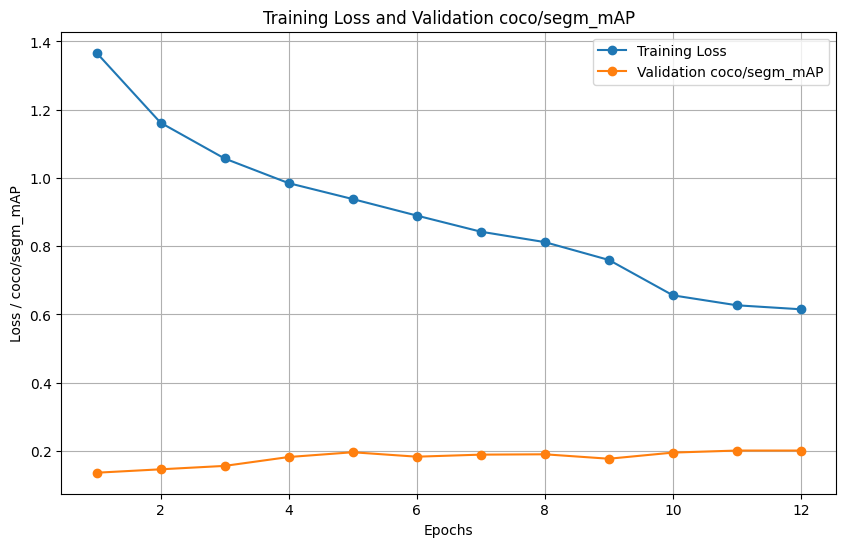

In [2]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_10/20240424_123908/vis_data/20240424_123908.json")

### Exp_12
Toch Exp 10 wat verder trainen, gezien het optimum de een na laatste is...

In [7]:
from mmengine import Config
cfg = Config.fromfile('../configs/cascade_rcnn/cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco.py')

In [8]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('Zonnepaneel', ),
    'palette': [(220, 20, 60),]
}

# Modify dataset type and path
cfg.data_root = 'Data/ortho'

cfg.train_dataloader.dataset.dataset.ann_file = 'train/annotations.json'
cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validation/annotations.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validation/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotations.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/validation/annotations.json'
cfg.val_evaluator.metric = ['bbox', 'segm']
cfg.test_evaluator.ann_file = cfg.data_root+'/test/annotations.json'
cfg.test_evaluator.metric = ['bbox', 'segm']

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# Train further from last epoch of experiment 10
cfg.load_from = 'Exp_10/epoch_12.pth'
cfg.resume = True

# Set up working dir to save files and logs.
cfg.work_dir = './Exp_12'

# Adjust max epochs
cfg.train_cfg.max_epochs = 18

# Set validation and checkpoint interval
cfg.train_cfg.val_interval = 1
cfg.default_hooks.checkpoint.interval = 1

cfg.optim_wrapper.optimizer.lr = 0.02 / 8

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend')]

#------------------------------------------------------
config=f'../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_ortho2.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [9]:
!python ../tools/train.py {config}

04/29 09:30:38 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 266332053
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

Validation mAP:  [0.136, 0.146, 0.156, 0.182, 0.196, 0.183, 0.189, 0.19, 0.177, 0.195, 0.201, 0.201, 0.2, 0.199, 0.2, 0.2, 0.2, 0.199]


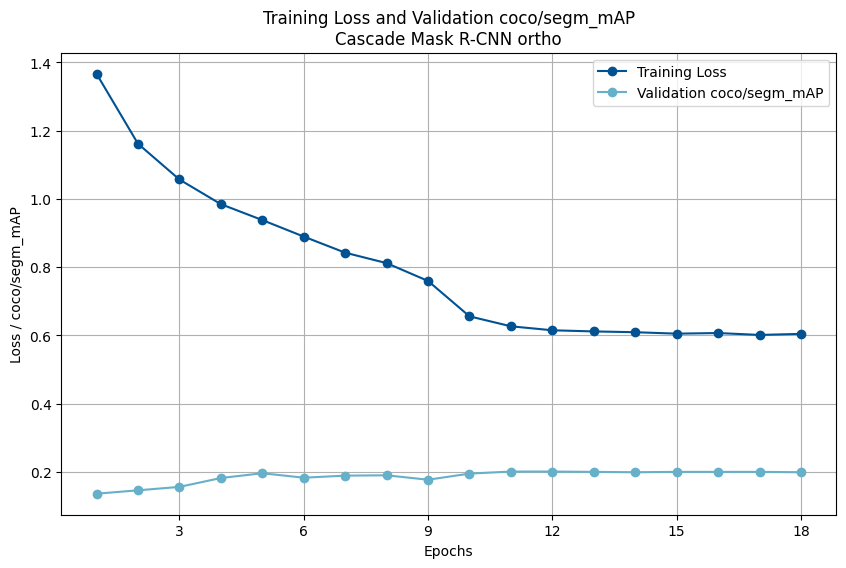

In [2]:
from custom_traininglog_plot import make_train_validation_plot

make_train_validation_plot("Exp_12/20240429_093037/vis_data/20240429_093037.json", "Cascade Mask R-CNN ortho")

In [12]:
!python ../tools/test.py \
../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_ortho2.py \
Exp_10/epoch_11.pth \
--work-dir Exp_10/detection_results \
--out results_exp10.pkl

04/29 11:11:01 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 125311519
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=comput

In [14]:
!python ../tools/analysis_tools/calculate_segm_metrics.py \
../configs/solar_panels/cascade-mask-rcnn_r50-caffe_fpn_ms-4x_zonnepaneel_ortho2.py \
results_exp10.pkl \
Exp_10 \
--show

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 369/369, 0.2 task/s, elapsed: 2208s, ETA:     0sFigure(720x720)
